In [1]:
# set up the automatic reload of modules
%load_ext autoreload
%autoreload 2
import torch, math, itertools
import matplotlib.pyplot as plt
import seaborn as sns           # for prettier heat-maps
sns.set_context("notebook")

In [2]:
from Network_models.HMMModels import HMMModel_linearK
from itertools import product


# --- tiny wrapper from your class ------------------------------
class ToyHMM(HMMModel_linearK):
    def __init__(self):
        super().__init__(z_dim=2, stim_types=1)     # K=2, one stim bit
        with torch.no_grad():
            self.logpi.copy_(torch.log(torch.tensor([0.6, 0.4])))

            # base transition
            self.logK_base.copy_(torch.log(torch.tensor([[0.7, 0.3],
                                                         [0.2, 0.8]])))
            # stimulus modulation
            self.logK_stim[0].copy_(torch.log(torch.tensor([[0.3, 0.7],
                                                            [0.6, 0.4]])))

            # grounding = identity
            self.logK_grounding.copy_(torch.log(torch.eye(2)))

            # emissions: symbols {Left(0), Right(1), None(2)}
            self.logP.copy_(torch.log(torch.tensor([[0.8, 0.1, 0.1],
                                                    [0.2, 0.7, 0.1]])))
        self.get_params()

toy = ToyHMM()

tensor([0.])
torch.Size([1, 2, 2]) torch.Size([1])
tensor([1.])
torch.Size([1, 2, 2]) torch.Size([1])


In [3]:
s = torch.tensor([[0, 1, 0, 0],   # seq-0 stimulus
                  [1, 0, 0, 0]])  # seq-1 stimulus
x = torch.tensor([[0, 0, 1, 2],   # actions (2 = padding)
                  [1, 2, 1,0]])
mask = torch.tensor([[1, 1, 0, 1],
                     [1, 0, 0, 1]])

In [4]:
lgamma, lxi, lalpha, lbeta, loglik = toy.forward_backward(s, x, mask)
gamma = lgamma.exp()
xi    = lxi.exp()

print("Seq-wise log-lik:", loglik.tolist())

Seq-wise log-lik: [-3.4896018505096436, -1.877102255821228]


In [5]:
for t in range(lalpha.shape[1]): 
    ll = torch.logsumexp(lalpha[:,t,:] + lbeta[:,t,:] + loglik.unsqueeze(1), dim=-1)
    print(f"t={t}, log-lik={ll.tolist()}")

t=0, log-lik=[-3.4896018505096436, -1.8771023750305176]
t=1, log-lik=[-3.4896018505096436, -1.8771023750305176]
t=2, log-lik=[-3.4896018505096436, -1.8771023750305176]
t=3, log-lik=[-3.4896018505096436, -1.877102255821228]


In [6]:
# γ rows should sum to 1 on valid steps
assert torch.allclose(gamma.sum(-1), mask.float(), atol=1e-6)

# ξ rows should sum to 1 on transitions that are not padding
assert torch.allclose(xi.sum(-1).sum(-1), mask[:,1:].float(), atol=1e-6)

# αβ cross-check
t_pick = 1
lhs = torch.logsumexp(lalpha[:,t_pick,:] + lbeta[:,t_pick,:] + loglik.unsqueeze(1), dim=-1)
print(f"t={t_pick}, log-lik={lhs.tolist()}, should be equal to {loglik}")
assert torch.allclose(lhs, loglik, atol=1e-5)
print("All invariants passed ✓")

t=1, log-lik=[-3.4896018505096436, -1.8771023750305176], should be equal to tensor([-3.4896, -1.8771], grad_fn=<LogsumexpBackward0>)
All invariants passed ✓


# Test the fitter now. 

In [29]:
from Network_models.HMMModels import HMMModel_linearK
K, stim_bits = 3, 3
bmodel = HMMModel_linearK(z_dim=K, stim_types=stim_bits)
bmodel.logP.data = torch.eye(K, dtype=bmodel.logK_stim.dtype, device=bmodel.logK_stim.device).log()[:, :]
bmodel.get_params()   # initialise K,P,pi tensors

model = HMMModel_linearK(z_dim=K, stim_types=stim_bits)
model.get_params()   # initialise K,P,pi tensors

tensor([0., 0., 0.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([0., 0., 1.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([0., 1., 0.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([0., 1., 1.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([1., 0., 0.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([1., 0., 1.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([1., 1., 0.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([1., 1., 1.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([0., 0., 0.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([0., 0., 1.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([0., 1., 0.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([0., 1., 1.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([1., 0., 0.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([1., 0., 1.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([1., 1., 0.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([1., 1., 1.])
torch.Size([3, 3, 3]) torch.Size([3])


(tensor([[[0.3380, 0.5123, 0.1123],
          [0.4799, 0.4418, 0.7392],
          [0.1821, 0.0459, 0.1486]],
 
         [[0.2099, 0.4780, 0.0168],
          [0.4447, 0.3547, 0.9237],
          [0.3454, 0.1673, 0.0595]],
 
         [[0.6615, 0.3259, 0.3443],
          [0.2598, 0.6504, 0.5806],
          [0.0786, 0.0237, 0.0751]],
 
         [[0.5131, 0.3332, 0.0638],
          [0.3007, 0.5722, 0.8990],
          [0.1862, 0.0946, 0.0372]],
 
         [[0.6911, 0.9562, 0.0584],
          [0.2204, 0.0297, 0.7878],
          [0.0885, 0.0141, 0.1538]],
 
         [[0.5357, 0.9223, 0.0083],
          [0.2549, 0.0247, 0.9333],
          [0.2094, 0.0531, 0.0584]],
 
         [[0.8957, 0.9227, 0.2044],
          [0.0790, 0.0663, 0.7068],
          [0.0253, 0.0110, 0.0888]],
 
         [[0.8211, 0.9021, 0.0322],
          [0.1081, 0.0558, 0.9303],
          [0.0708, 0.0421, 0.0375]],
 
         [[0.5216, 0.7690, 0.0839],
          [0.3907, 0.1867, 0.8111],
          [0.0877, 0.0443, 0.1051]]], gr

In [105]:
def sample_sequence(model, T=4):
    S = model.S
    s = torch.randint(0, S, (T,))                 # stimuli
    z, x = [], []
    state = torch.multinomial(model.pi, 1).item()
    for t in range(T):
        # emission
        # transition
        next_state = torch.multinomial(model.K[s[t], state], 1).item()
        state = next_state
        sym = torch.multinomial(model.P[state], 1).item()
        z.append(state);  x.append(sym)
    return torch.tensor(s), torch.tensor(x)

B = 256
s_batch, x_batch = [], []
for _ in range(B):
    s, x = sample_sequence(bmodel, 1024)
    s_batch.append(s); x_batch.append(x)
s = torch.stack(s_batch)               # (B,T)
x = torch.stack(x_batch)               # (B,T)
mask = torch.ones_like(x)

/tmp/ipykernel_48853/996236490.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(s), torch.tensor(x)


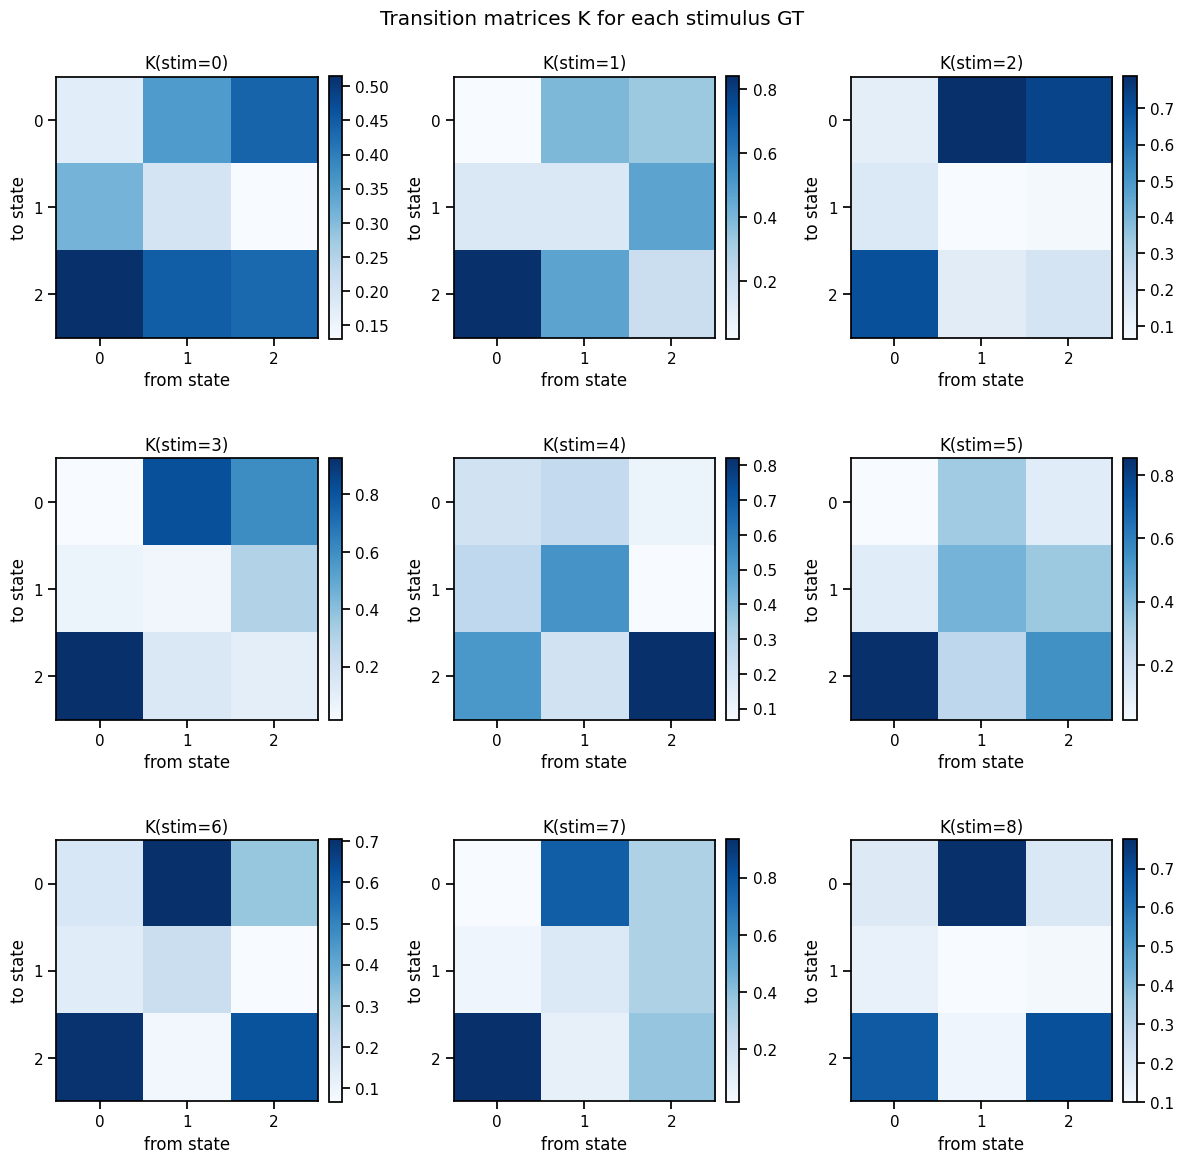

In [106]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for stim in range(9):
    ax = axes[stim // 3, stim % 3]
    im = ax.imshow(bmodel.K[stim].cpu().detach(), cmap="Blues", origin="upper")
    ax.set_title(f"K(stim={stim})")
    ax.set_xlabel("from state")
    ax.set_ylabel("to state")
    ax.set_xticks(range(bmodel.K.shape[2]))
    ax.set_yticks(range(bmodel.K.shape[1]))
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.suptitle("Transition matrices K for each stimulus GT")
plt.tight_layout()
plt.show()

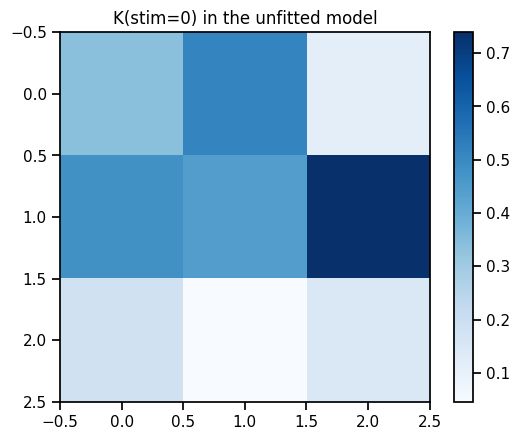

In [32]:
plt.imshow(model.K[0].cpu().detach(), cmap="Blues")
plt.title("K(stim=0) in the unfitted model"); plt.colorbar(); plt.show()

In [128]:
from Network_models.HMMModels import HMMModel_linearK
stim_bits = 3
model = HMMModel_linearK(z_dim=K, stim_types=stim_bits)
# model.fix_P(bmodel.P + 1e-8)

model.get_params()   # initialise K,P,pi tensors
K_seq = [model.K[0].cpu().detach().numpy()]
P_seq = [model.P.cpu().detach().numpy()]
pi_seq = [model.pi.cpu().detach().numpy()]
epochs = 16
ll_seq = []

model.to("cuda")
for epoch in range(epochs):
    # model.zero_grad()
    ll = model.fit_batch(s.cuda(), x.cuda(), mask.cuda())
    ll_seq.append(ll.mean().item())
    K_seq.append(model.K[0].cpu().detach().numpy())
    P_seq.append(model.P.cpu().detach().numpy())
    pi_seq.append(model.pi.cpu().detach().numpy())
    print(f"Epoch {epoch+1}/{epochs}, log-lik={ll.mean().item():.3f}")
    

Epoch 1/16, log-lik=-1236.289
Epoch 2/16, log-lik=-1126.239
Epoch 3/16, log-lik=-1134.363
Epoch 4/16, log-lik=-1131.341
Epoch 5/16, log-lik=-1125.202
Epoch 6/16, log-lik=-1124.349
Epoch 7/16, log-lik=-1124.336
Epoch 8/16, log-lik=-1124.348
Epoch 9/16, log-lik=-1124.348
Epoch 10/16, log-lik=-1124.348
Epoch 11/16, log-lik=-1124.348
Epoch 12/16, log-lik=-1124.348
Epoch 13/16, log-lik=-1124.348
Epoch 14/16, log-lik=-1124.348
Epoch 15/16, log-lik=-1124.348
Epoch 16/16, log-lik=-1124.348


In [136]:
bmodel.P += 1e-8
bmodel.to("cuda")
bmodel.forward_backward(s.cuda(), x.cuda(), mask.cuda())

(tensor([[[-2.0425e+01,  0.0000e+00, -1.8174e+01],
          [ 0.0000e+00, -2.0622e+01, -2.0360e+01],
          [-2.0415e+01, -2.1160e+01,  0.0000e+00],
          ...,
          [-1.8635e+01,  0.0000e+00, -1.9140e+01],
          [-1.9159e+01,  0.0000e+00, -1.8425e+01],
          [ 0.0000e+00, -1.8312e+01, -1.7496e+01]],
 
         [[ 0.0000e+00, -1.8506e+01, -1.7455e+01],
          [-1.8364e+01, -1.1921e-07, -1.5659e+01],
          [-2.0754e+01, -1.8768e+01,  0.0000e+00],
          ...,
          [ 0.0000e+00, -1.8436e+01, -1.8333e+01],
          [-1.7350e+01, -5.9605e-07, -1.4459e+01],
          [-1.5548e+01, -1.7223e+01, -1.1921e-07]],
 
         [[-2.1738e+01, -1.7966e+01,  0.0000e+00],
          [ 0.0000e+00, -1.8010e+01, -2.0292e+01],
          [-1.6333e+01, -2.3842e-07, -1.5349e+01],
          ...,
          [-1.4646e+01, -1.8695e+01, -4.7684e-07],
          [-1.7155e+01, -1.8092e+01,  0.0000e+00],
          [-1.5464e+01, -2.3842e-07, -1.6803e+01]],
 
         ...,
 
         [[ 

In [121]:
ll_seq2 = ll_seq

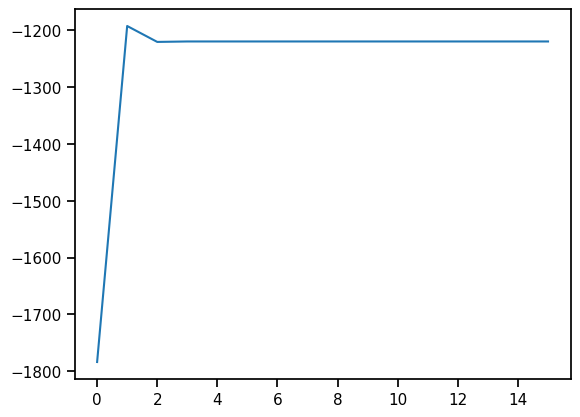

In [120]:
plt.plot(ll_seq)

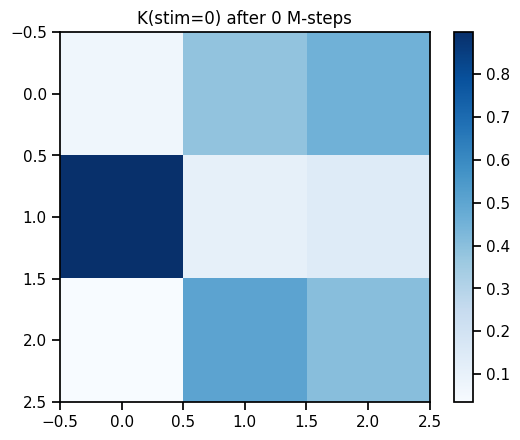

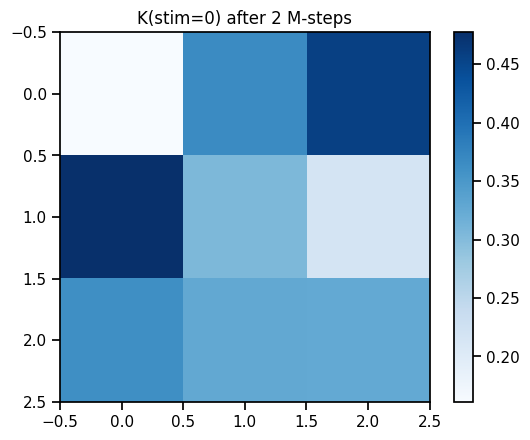

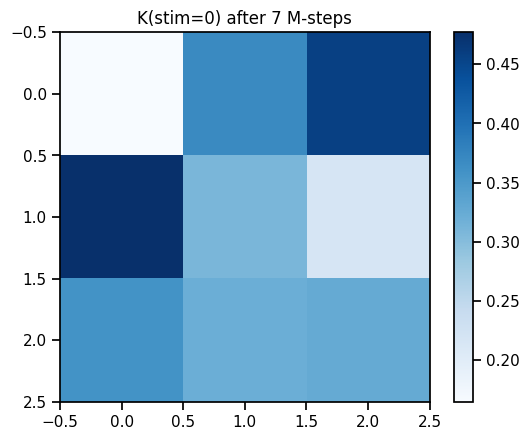

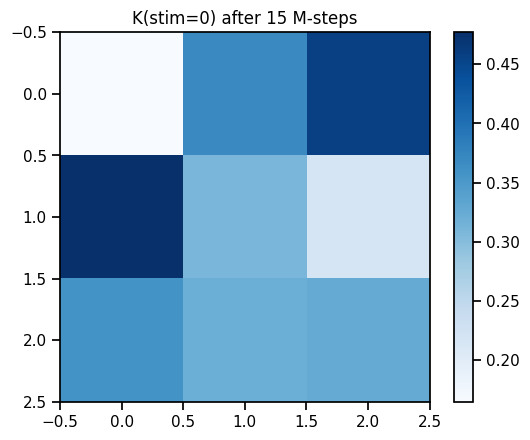

In [109]:
plotted = [0, 2, 7, 15]
for idx in plotted:
    plt.imshow(K_seq[idx], cmap="Blues")
    plt.title(f"K(stim=0) after {idx} M-steps"); plt.colorbar(); plt.show()

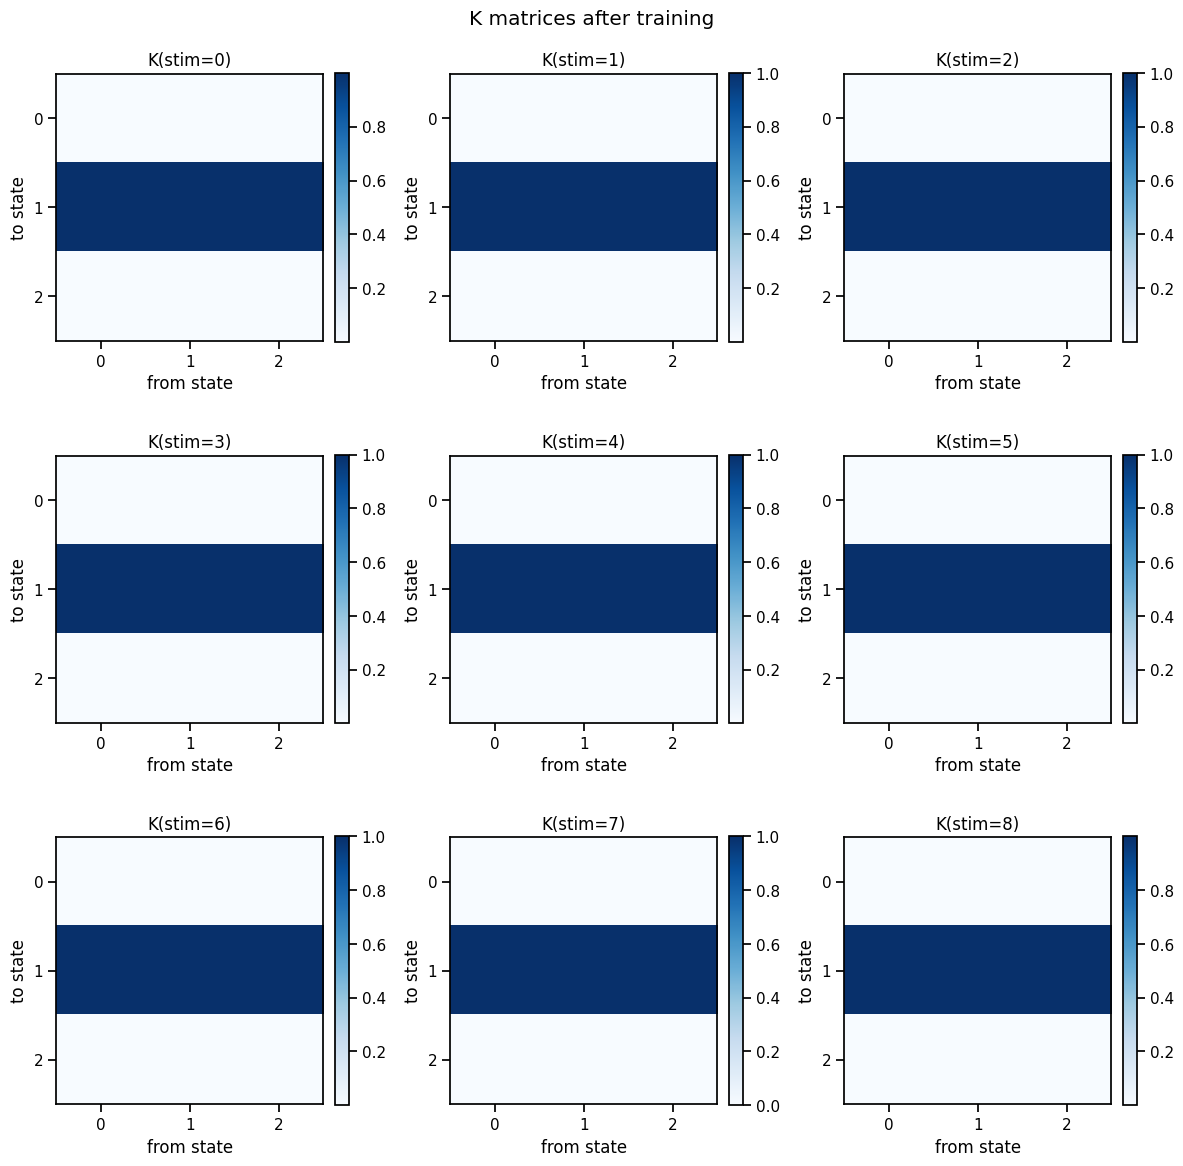

In [129]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for stim in range(9):
    ax = axes[stim // 3, stim % 3]
    im = ax.imshow(model.K[stim].cpu().detach(), cmap="Blues", origin="upper")
    ax.set_title(f"K(stim={stim})")
    ax.set_xlabel("from state")
    ax.set_ylabel("to state")
    ax.set_xticks(range(model.K.shape[2]))
    ax.set_yticks(range(model.K.shape[1]))
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.suptitle("K matrices after training")
plt.tight_layout()
plt.show()

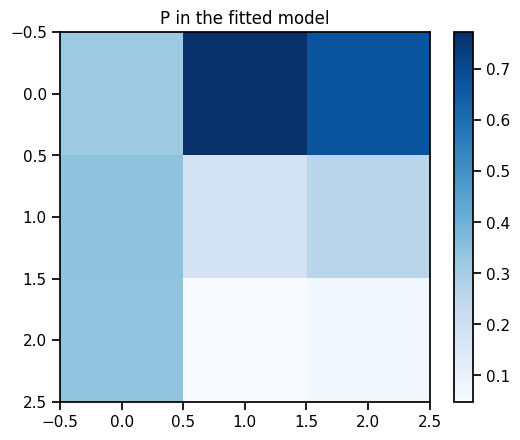

In [127]:
plt.imshow(model.P.T.cpu().detach(), cmap="Blues")
plt.title("P in the fitted model"); plt.colorbar(); plt.show()


In [115]:
model.P[1, :]

tensor([0.3172, 0.3446, 0.3382], device='cuda:0', grad_fn=<SliceBackward0>)

In [116]:
print(f"Overall preference for symbol 0: {x[x == 0].shape[0] / (256 * 1024):.3f}")
print(f"Overall preference for symbol 1: {x[x == 1].shape[0] / (256 * 1024):.3f}")
print(f"Overall preference for symbol 2: {x[x == 2].shape[0] / (256 * 1024):.3f}")

Overall preference for symbol 0: 0.317
Overall preference for symbol 1: 0.345
Overall preference for symbol 2: 0.338


tensor([0., 0., 0.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([0., 0., 1.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([0., 1., 0.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([0., 1., 1.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([1., 0., 0.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([1., 0., 1.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([1., 1., 0.])
torch.Size([3, 3, 3]) torch.Size([3])
tensor([1., 1., 1.])
torch.Size([3, 3, 3]) torch.Size([3])


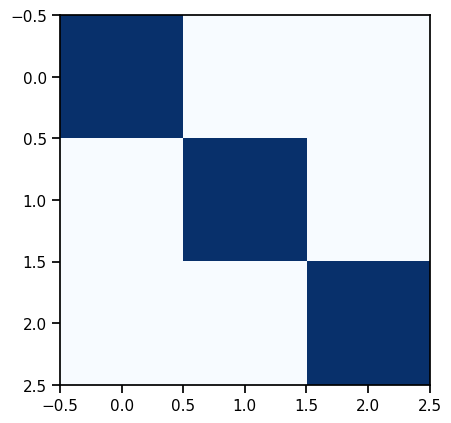

In [16]:
bmodel.get_params()   # initialise K,P,pi tensors
plt.imshow(bmodel.P.cpu().detach(), cmap="Blues")

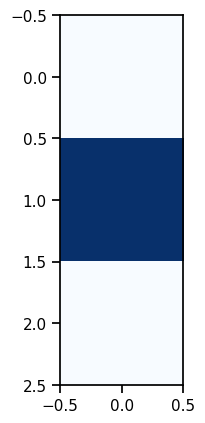

In [177]:
plt.imshow(model.pi.unsqueeze(1).cpu().detach(), cmap="Blues")

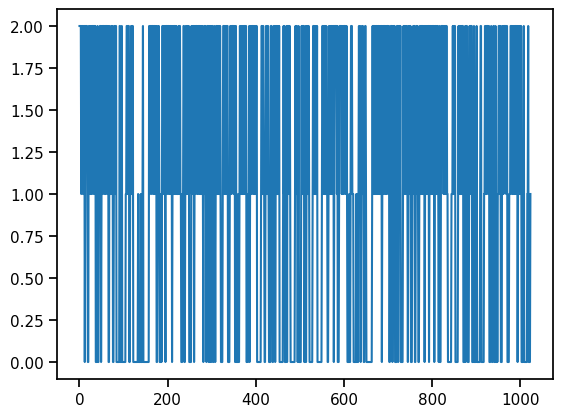

In [25]:
plt.plot(x_batch[9].cpu().numpy(), label="x")

In [72]:
s_batch_pred, x_batch_pred = [], []
for _ in range(B):
    s, x = sample_sequence(model, 1024)
    s_batch_pred.append(s); x_batch_pred.append(x)
s_pred = torch.stack(s_batch_pred)               # (B,T)
x_pred = torch.stack(x_batch_pred)               # (B,T)
# mask = torch.ones_like(x)

/tmp/ipykernel_48853/2544371303.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(s), torch.tensor(x)


In [73]:
print(f"Overall preference for symbol 0: {x_pred[x_pred == 0].shape[0] / (256 * 1024):.3f}")
print(f"Overall preference for symbol 1: {x_pred[x_pred == 1].shape[0] / (256 * 1024):.3f}")
print(f"Overall preference for symbol 2: {x_pred[x_pred == 2].shape[0] / (256 * 1024):.3f}")

Overall preference for symbol 0: 0.327
Overall preference for symbol 1: 0.339
Overall preference for symbol 2: 0.334


In [27]:
x_pred.shape.

torch.Size([256, 1024])